# Measuring Distance Using Convolutional Neural Network

In signal processing, it is sometimes necessary to measure distance between some features of the signal, for example, the peaks. A good example of this could be interpreting an electrocardiogram (ECG), which relies on measuring distances for much of its interpretation. So, I decided to dedicate to this problem some time and represent two ways of solving it. The first way is very easy and straightforward. It consists of finding the peaks in one-dimensional signal and then then measuring the distance between them by subtracting their coordinates. Another way is to use a small neural network to do the same task. 

The reason why you would use a neural network for such a simple task is when you want to incorporate distance measuring as a part of a larger machine learning problem(such as interpreting ECG) and want to use end-to-end learning for this task.


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.signal import find_peaks
from sklearn.metrics import mean_squared_error, r2_score
import time

## Generating data

First, we create a generator function that generates the data we will use for both training and test sets. This is a python generator function, meaning that it uses `yield` keyword instead of `return`. Every time a `next()` function on a generator is called it will yield the next result. This function generates signals with exactly two peaks. All the signals are exactly the same length. The location of the first peak is uniformly distributed in the first quadrant of the signal, but the location of the second peak is normally distributed, but we also make sure it does not go outside the bounds. The peaks’ widths are also normally distributed. We return the peaks in batches, which would be useful for neural network training and evaluation. 
Note that this generator literally generates infinite amount of data! By virtue of this, we can try to achieve as high accuracy as possible for our toy example.


In [ ]:
def get_signal_generator(batch_size, n_points, mean_distance, std_distance, 
                         mean_width, std_width):
    def generate_one():
        first = np.random.uniform(0, n_points /4)
        second = first + np.random.normal(mean_distance * n_points, std_distance * n_points)
        if second > n_points * 0.95:
            second = n_points * 0.95
        distance = second - first
        first_width = max(np.random.normal(mean_width * n_points, std_width * n_points), n_points * std_width)
        second_width = max(np.random.normal(mean_width * n_points, std_width * n_points), n_points * std_width)
        data_range = np.arange(n_points)
        signal = norm.pdf(data_range, first, first_width) + \
            norm.pdf(data_range, second, second_width)
        return signal, distance
        
    def generate():
        sanity=100000
        for _ in range(sanity):
            all_data = [generate_one() for _ in range(batch_size)]
            yield np.vstack([element[0] for element in all_data]), np.vstack([element[1] for element in all_data])
        
    return generate()

Calling `next()` function returns the next batch. We can see below an example of the signal we will process in this arcicle

In [ ]:
data_generator = get_signal_generator(2, 1000, 0.3, 0.1, 0.03, 0.01)
batch = next(data_generator)

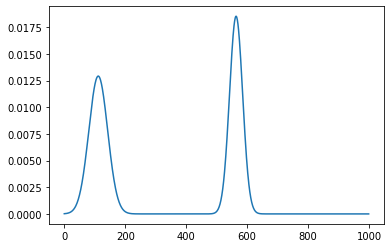

In [ ]:
plt.plot(batch[0][0,:]);

## Finding peaks

Now that we have the generator function, we can use the standard signal processing library to find the distance between peaks. We will use `scipy` library and function `find_peaks()` to find peaks. 


In [ ]:
def predict_distance(batch):
    def compute_distance(row):
        peaks = find_peaks(row)[0]
        if len(peaks) < 2:
            return 0
        return abs(peaks[1] - peaks[0])
                   
    return np.vstack([compute_distance(batch[i,:]) for i in range(batch.shape[0])])
    

We use $R^2$ score to evaluate the model. As we can see, we get almost perfect score and the prediction error is mostly due to number rounding error.

In [ ]:
np.random.seed(2128506)
data_generator = get_signal_generator(500, 1000, 0.7, 0.1, 0.03, 0.01)
batch_x, batch_y = next(data_generator)

In [ ]:
predictions = predict_distance(batch_x)
print('Baseline performance: ', r2_score(batch_y, predictions))

Baseline performance:  0.9999812121197582


## Using CNN to measure distances

When designing a neural network, it is often useful to imaging what would a human operator do. In our case the operation is measuring and the instrument of it is a ruler. In our case we simulate a ruler using a 1D convolutional layer with the kernel size set to the maximum – the length of the signal. The reasoning behind this is that if the layer has values from 0,1,2,3,4,… when multiplied by the signal it would accurately give us the position of the peak. We use two filters, supposedly to measure the position of two peaks, and then add two fully connected layers to let the neural network learn how to take the difference between these two measurements.

Our implementation of the neural network uses Tensorflow and Keras. Note, that since `Conv1D` requires a three-dimensional tensor, we add a Reshape layer that adds the third dimension of the size 1. Batch dimension is implicitly assumed. For the convolution layer we do not use any activation function, because we want the behaviour of the layer resemble a ruler. Before sending the data to `Dense` layers we add a `Flatten` layer to collapse dimensions (except the batch dimension) into a single dimension because this is what `Dense` layer expects. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dense, Input, Reshape, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential([
    Input(shape=(1000,)),
    Reshape((-1,1)),      
    Conv1D(filters=2, kernel_size=1000, activation=None),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(lr=0.7), loss='mse')
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_26 (Reshape)         (None, 1000, 1)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 1, 2)              2002      
_________________________________________________________________
flatten_25 (Flatten)         (None, 2)                 0         
_________________________________________________________________
dense_63 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_64 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 17        
Total params: 2,339
Trainable params: 2,339
Non-trainable params: 0
___________________________________________________

As we see, this model has only 2339 parameters, so it is a pretty simple model. We train the model during 50 epochs, but we also added `Early S


In [ ]:
np.random.seed(2128506)
tf.random.set_seed(2128506)
data_generator = get_signal_generator(500, 1000, 0.7, 0.1, 0.03, 0.01)
model.fit(data_generator, epochs=50, steps_per_epoch=100, callbacks=[EarlyStopping(monitor='loss'), TerminateOnNaN()])

Epoch 1/50
100/100 [==============================] - 16s 157ms/step - loss: 55010.6915
Epoch 2/50
100/100 [==============================] - 16s 161ms/step - loss: 186.3050
Epoch 3/50
100/100 [==============================] - 16s 160ms/step - loss: 89.9977
Epoch 4/50
100/100 [==============================] - 16s 159ms/step - loss: 229.8199


In [ ]:
time.sleep(1)
batch_x, batch_y = next(data_generator)
predictions = model.predict(batch_x)
print('R^2 score: ', r2_score(batch_y, np.squeeze(predictions)))

R^2 score:  0.996036173273703


As we see, this model has only 2339 parameters, so it is a pretty simple model. We train the model during 50 epochs, but we also added `EarlyStopping` callback to stop execution of the model if it stops being improved. We add another callback `TerminateOnNaN` that stops the training process if the gradients or loss becomes `NaN`. 
We pass a generator function to the `fit()` method. This is now a recommended method of passing data to the model, especially when the volume of data is large. In our case the generator continuously generates random examples, literally infinite number of examples! Since our generator function does not have a concept of an epoch, we need to define a parameter `steps_per_epoch`, otherwise the model will think all the batches belong to the first epoch and the training will never end.
After training a model we see, that the test set score is truly impressive. While we acknowledge that further improvements to the algorithm are possible, the result we got proves that our simple approach really works.
